# PREVISÃO DA VELOCIDADE DO VENTO A CURTO PRAZO USANDO REDES NEURAIS QUÂNTICAS EM MUCURI PARA 3 HORAS SIMULTÂNEAS, BAHIA


## Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pennylane as qml
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend, optimizers, activations
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score

from math import sqrt
from scipy import stats
from datetime import datetime,timedelta

tf.keras.backend.set_floatx('float64')

## Carregando os Dados

In [2]:
def carregar_tabela(arquivo):
    # Carregando dataset
    dataset_train = pd.read_csv(arquivo, sep='\t', header = 0)

    # Separando os valores entre dados de entrada e dados a serem preditos 
    # (X e Y) Utilizado apenas a coluna de velocidade e removido o primeiro
    # índice para prever a próxima velocidade
    y_train_all = dataset_train[:].drop(dataset_train.index[0])
    # Remove a ultima linha do X pois não o predito Y não terá uma linha a mais
    X_train_all = dataset_train.iloc[:-3,:]
    

    y_train_all['1h - Vento'] = y_train_all.iloc[:,4].shift(0)
    y_train_all['2h - Vento'] = y_train_all.iloc[:,4].shift(-1)
    y_train_all['3h - Vento'] = y_train_all.iloc[:,4].shift(-2)
    y_train_all = y_train_all.iloc[:-2,-3:]
    
    return X_train_all.iloc[:,-5:],y_train_all['1h - Vento'].values

In [3]:
filename = 'train150_mucuri.txt'

X_train_all,y_train_all = carregar_tabela(filename)
y_train_all = y_train_all.reshape(-1,1)

n_features = X_train_all.shape[1]
n_instances = X_train_all.shape[0]
print(f"There are {n_features} features and {n_instances} instâncias")
X_train_all.head()

There are 5 features and 547 instâncias


,Velocidade,Direção,Temperatura,Umidade,Pressão
0,13.012139,75.105481,27.516129,72.930636,1020.422601
1,12.726087,68.334332,27.238095,75.212121,1020.394348
2,12.081111,64.457865,27.105263,75.741379,1020.508333
3,11.647222,53.842100,26.305556,75.302632,1020.611000
4,11.064444,53.945279,25.464286,76.592593,1020.866500


# Normalizando

In [4]:
scaler_x = MinMaxScaler(feature_range=(-1, 1))
X_train_scaled = scaler_x.fit_transform(X_train_all)

scaler_y = MinMaxScaler(feature_range=(-1, 1))
y_train_scaled = scaler_y.fit_transform(y_train_all)

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train_scaled, test_size=0.2)

# Rede Quântica 

In [6]:
def H_layer(n_qubits):
    for idx in range(n_qubits):
        qml.Hadamard(wires=idx)

def Data_AngleEmbedding_layer(inputs, n_qubits):
    qml.templates.AngleEmbedding(inputs,rotation='Y', wires=range(n_qubits))

def RY_layer(w):
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def ROT_layer(w):
    for i in range(len(w)):
        qml.Rot(*w[i],wires=i)

def strong_entangling_layer(nqubits):
    for i in range(nqubits-1): 
        qml.CNOT(wires=[i, i+1])
    qml.CNOT(wires=[nqubits-1,0])
    
def entangling_layer(nqubits):
    for i in range(0, nqubits - 1, 2): 
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):  
        qml.CNOT(wires=[i, i + 1])

In [7]:
n_qubits = n_features
n_layers = 1
#n_layers = np.ceil(np.log(n_features))

#dev = qml.device('default.qubit', wires=n_qubits)
dev = qml.device('lightning.qubit', wires=n_qubits)
@qml.qnode(dev)
def qnode(inputs, weights_1):
    H_layer(n_qubits)
    Data_AngleEmbedding_layer(inputs, n_qubits)
    for k in range(n_layers):
        entangling_layer(n_qubits)
        ROT_layer(weights_1[k])
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

## Drawing Quantum Circuit

In [8]:
weight_shapes = {"weights_1": (n_layers,5,3)}

sampl_weights = np.random.uniform(low=0, high=np.pi, size=weight_shapes["weights_1"])
sampl_input = np.random.uniform(low=0, high=np.pi, size=(5,))
print(qml.draw(qnode, expansion_strategy="device")(sampl_input, sampl_weights))

0: ──H──RY(2.25)─╭●──Rot(2.47,1.61,1.69)──────────────────────┤  <Z>
1: ──H──RY(2.57)─╰X─╭●────────────────────Rot(3.10,3.06,1.93)─┤  <Z>
2: ──H──RY(1.88)─╭●─╰X────────────────────Rot(0.93,2.10,0.45)─┤  <Z>
3: ──H──RY(0.81)─╰X─╭●────────────────────Rot(0.37,2.33,2.55)─┤  <Z>
4: ──H──RY(0.26)────╰X────────────────────Rot(1.29,3.12,0.55)─┤  <Z>


## Creating Quantum Model

In [9]:
q_layer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
Activation=tf.keras.layers.Activation(activations.linear)
output_layer = tf.keras.layers.Dense(1,kernel_initializer='normal')

opt = tf.keras.optimizers.Adam(learning_rate=0.1)

model = tf.keras.models.Sequential([q_layer,Activation, output_layer])
model.compile(opt, loss="mse")

In [10]:
input_shape = (n_qubits,)

model.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (5, 5)                    15        
                                                                 
 activation (Activation)     (5, 5)                    0         
                                                                 
 dense (Dense)               (5, 1)                    6         
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


### Criando o Compilador e Executando o treino

<table>
<tr>
    <th><p align="left">Variável</p></th>
    <th><p align="left">Valor</p></th>
<tr>
    <td><p align="left">Loss</p></td>
    <td><p align="left">MSE (Mean Square Error)</p></td>
</tr>
<tr>
    <td><p align="left">Optimizer</p></td>
    <td><p align="left">SGD</p></td>
</tr>
<tr>
    <td><p align="left">Metrics</p></td>
    <td><p align="left">MAE (Mean Absolute Error)</p></td>
</tr>
<tr>
    <td><p align="left">Epochs</p></td>
    <td><p align="left">1000</p></td>
</tr>
<tr>
    <td><p align="left">Batch_Size</p></td>
    <td><p align="left">16</p></td>
</tr>
<tr>
    <td><p align="left">Verbose</p></td>
    <td><p align="left">2 (Exibir apenas o Epoch com o Loss e a Metric)</p></td>
</tr>
<tr>
    <td><p align="left">tx (Taxa de Aprendizado)</p></td>
    <td><p align="left">0.01</p></td>
</tr>
</table>

In [11]:
# Fit retorna histórico do modelo
X_train = tf.cast(X_train, dtype=tf.float64)
y_train = tf.cast(y_train, dtype=tf.float64)
es=EarlyStopping(monitor='val_loss', min_delta=0, patience=6, verbose=1, mode='auto', baseline=None, restore_best_weights=True)
re=ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='min', min_lr=0.00001)
history_model = model.fit(X_train, y_train, epochs=50, batch_size=1, callbacks=[re], verbose=1, validation_data=(X_val, y_val))

Epoch 1/50
437/437 [==============================] - 55s 126ms/step - loss: 0.0705 - val_loss: 0.0436 - lr: 0.1000
Epoch 2/50
437/437 [==============================] - 56s 128ms/step - loss: 0.0574 - val_loss: 0.0324 - lr: 0.1000
Epoch 3/50
437/437 [==============================] - 57s 129ms/step - loss: 0.0581 - val_loss: 0.0781 - lr: 0.1000
Epoch 4/50
437/437 [==============================] - 59s 134ms/step - loss: 0.0631 - val_loss: 0.0334 - lr: 0.1000
Epoch 5/50
437/437 [==============================] - ETA: 0s - loss: 0.0679
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.010000000149011612.
437/437 [==============================] - 56s 127ms/step - loss: 0.0679 - val_loss: 0.0514 - lr: 0.1000
Epoch 6/50
437/437 [==============================] - 57s 130ms/step - loss: 0.0426 - val_loss: 0.0366 - lr: 0.0100
Epoch 7/50
437/437 [==============================] - 57s 131ms/step - loss: 0.0411 - val_loss: 0.0367 - lr: 0.0100
Epoch 8/50
437/437 [=======================

### Criando gráfico de Loss por Epoch

In [12]:
def plot_history(history):
    plt.figure(figsize=(14,5), dpi=320, facecolor='w', edgecolor='k')
    plt.title("Loss")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.plot(history.history['loss'], label="Loss/Epoch")
    plt.plot(history.history['val_loss'], label="Val Loss/Epoch")
    plt.legend()
    plt.show()

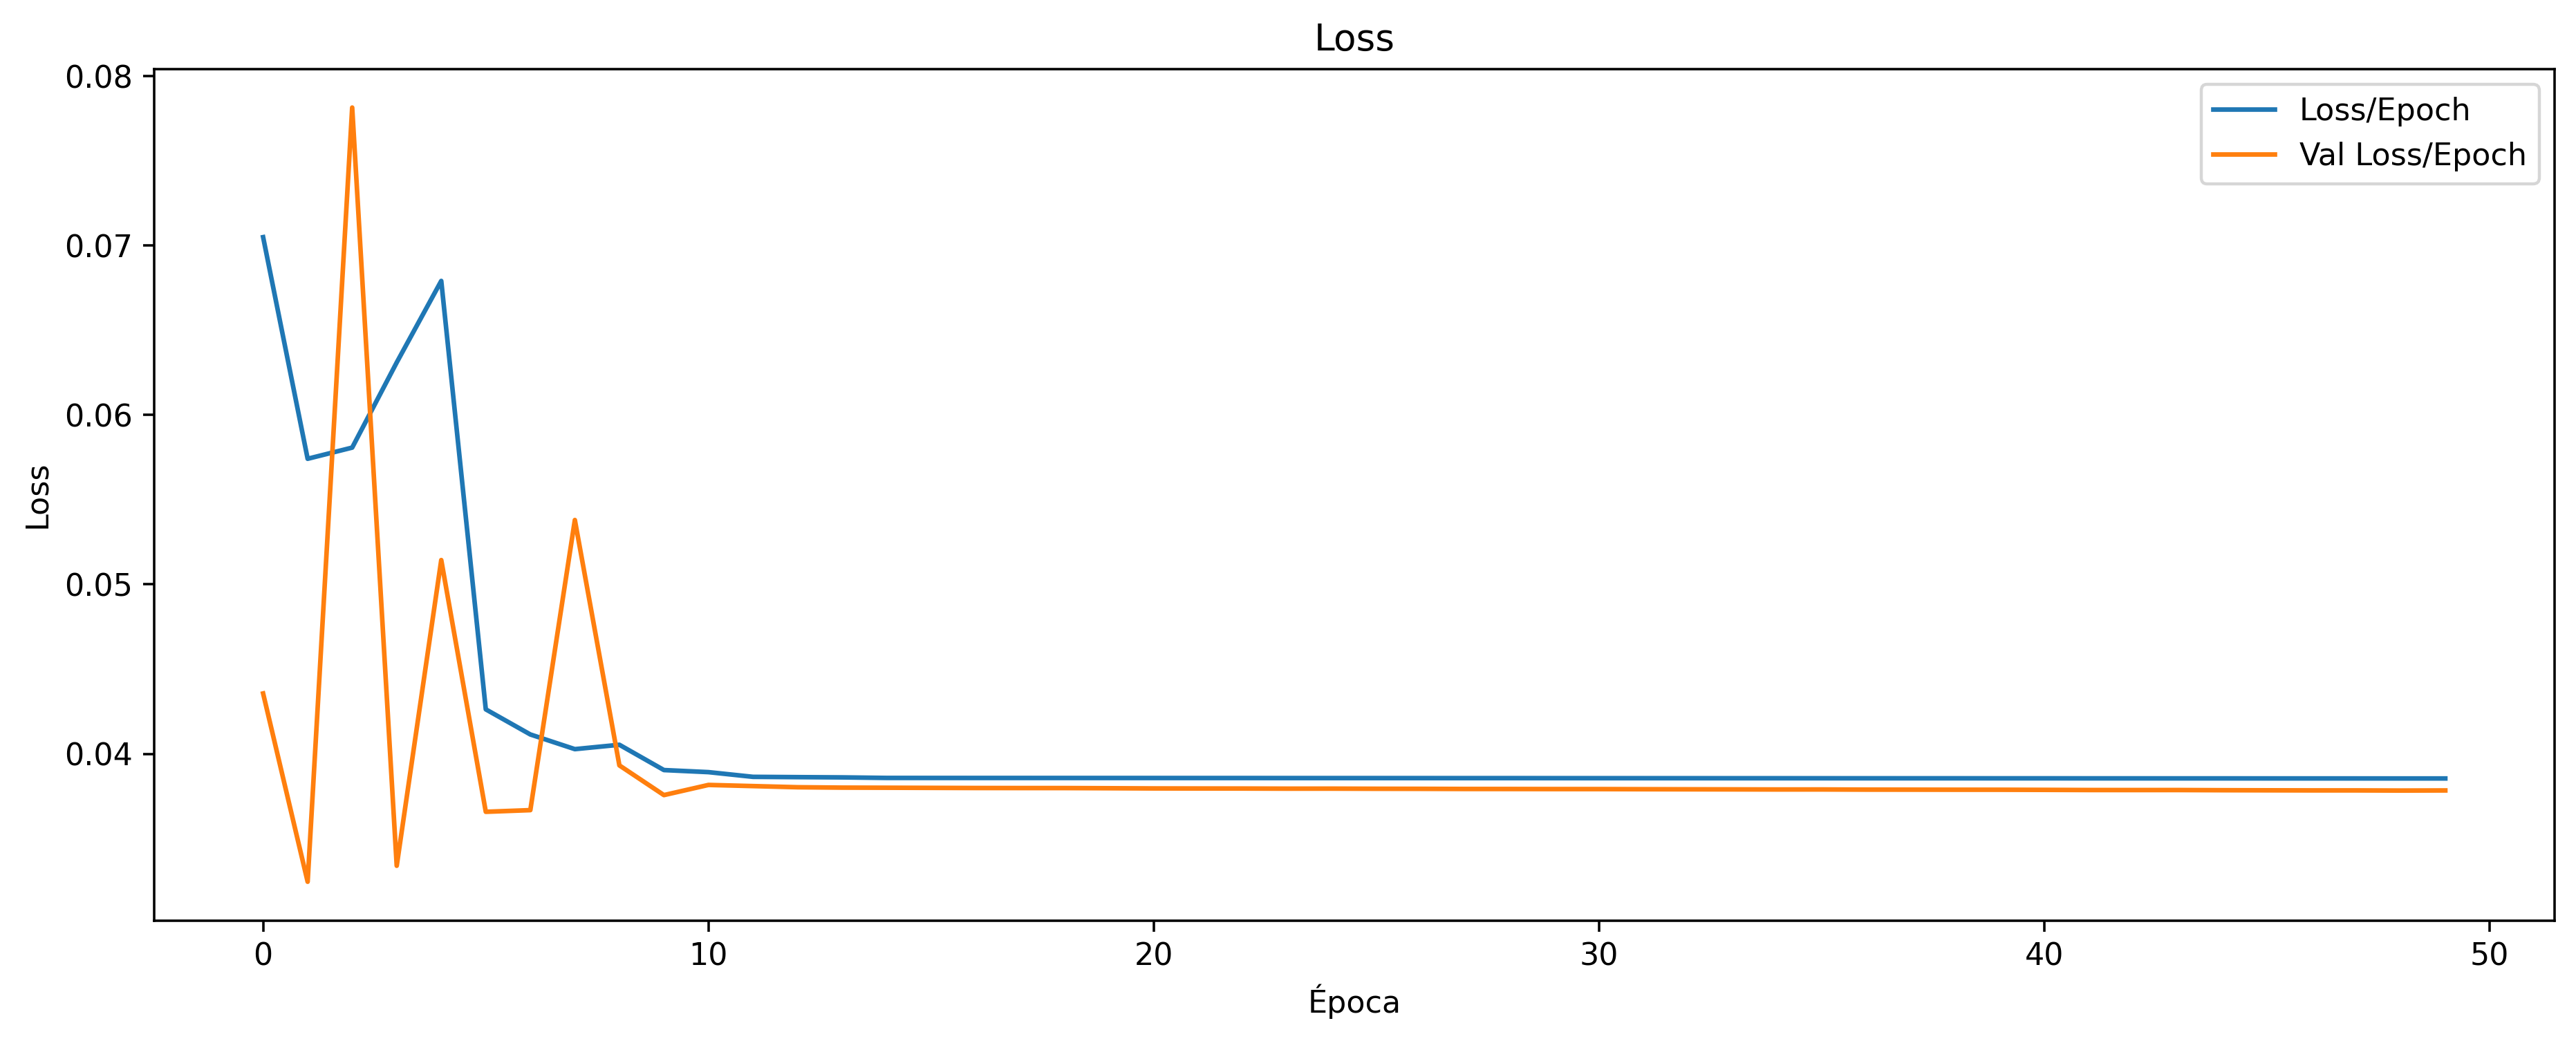

In [13]:
plot_history(history_model)

## Teste
### Carregando o Teste e executando a comparação entre original e predito

In [22]:
test = 'prev150_mucuri.txt'
X_test_all,y_test_all = carregar_tabela(test)
y_test_all = y_test_all.reshape(-1,1)
X_test_scaled = scaler_x.transform(X_test_all)
y_test_scaled = scaler_y.transform(y_test_all)

In [24]:
predito = model.predict(X_test_scaled, verbose=1)

6/6 [==============================] - 0s 76ms/step


In [25]:
predito_normal = scaler_y.inverse_transform(predito)

### Calculando o intervalo de confiança do erro de predição do modelo

In [34]:
def get_error_interval(model, X_val, Y_val, X_test, Y_test, y_test_pred, p_value):
    y_val_pred = model.predict(X_val)
    y_val_error = np.abs(Y_val - y_val_pred)
    error_quantile=np.ndarray((1,Y_val.shape[1]));
    for i in range(Y_val.shape[1]):
        error_quantile[0,i] = np.quantile(y_val_error[:,i], q=p_value, method='linear')
        
    y_test_interval_pred_left=np.ndarray(y_test_pred.shape);
    y_test_interval_pred_right=np.ndarray(y_test_pred.shape);
    
    for i in range(y_test_pred.shape[1]):
        y_test_interval_pred_left[:,i] = y_test_pred[:,i] - error_quantile[0,i]
        y_test_interval_pred_right[:,i] = y_test_pred[:,i] + error_quantile[0,i]
    return error_quantile, y_test_interval_pred_left, y_test_interval_pred_right

In [35]:
def get_mean_left_right_error_interval(model, y_scaler, y_test_pred):
    error, error_left, error_right = get_error_interval(model, X_val, y_val, X_test_scaled, y_test_scaled, y_test_pred, 0.95)
    
    error_left_normal = y_scaler.inverse_transform(error_left)
    error_right_normal = y_scaler.inverse_transform(error_right)

    mean_error_normal=np.ndarray((1,y_test_all.shape[1]));
    mean_error_left_normal=np.ndarray((1,y_test_all.shape[1]));
    mean_error_right_normal=np.ndarray((1,y_test_all.shape[1]));
    mean_predictions=np.ndarray((1,y_test_pred.shape[1]));

    for i in range(y_test_all.shape[1]):
        mean_error_left_normal[0,i] = np.mean(error_left_normal[:,i])
        mean_error_right_normal[0,i] = np.mean(error_right_normal[:,i])
        mean_predictions[0,i]=np.mean(y_test_pred[:,i])

    mean_error_normal=(mean_error_right_normal-mean_error_left_normal)/2
    return mean_predictions, mean_error_normal, mean_error_left_normal, mean_error_right_normal

In [36]:
mean_predictions, mean_error_normal, mean_error_left_normal, mean_error_right_normal = get_mean_left_right_error_interval(
    model, scaler_y, predito_normal)


### Plotando os gráficos de predição versus observado no teste, junto com as métricas

### Função de Estatística

In [37]:
def factor_of_2(y_true, y_pred):
    min_ = 0.5
    max_ = 2.0

    tensor_true = tf.constant(y_true)
    tensor_true = tf.cast(tensor_true, tf.float32)
    tensor_pred = tf.constant(y_pred)
    tensor_pred = tf.cast(tensor_pred, tf.float32)

    division = tf.divide(tensor_pred, tensor_true)

    greater_min = tf.greater_equal(division, min_)
    less_max = tf.less_equal(division, max_)

    res = tf.equal(greater_min, less_max)
    res = tf.cast(res, tf.float32)

    return backend.get_value(tf.reduce_mean(res))


def allmetrics(original,predito):
    r_value = 0
    slope, intercept, r_value, p_value, std_err = stats.linregress(original, predito)
    mse = mean_squared_error(original, predito)
    mae = mean_absolute_error(original, predito)
    rr = r2_score(original,predito)
    pea = stats.pearsonr(original, predito)
    fat = factor_of_2(original,predito)
    nmse = mse/stats.tvar(original)
    rmse = sqrt(mse)
    nrmse = rmse/stats.tstd(original)
    return mae,mse,nmse,r_value,rr,fat,rmse,nrmse

In [38]:
def get_plot_prediction_versus_observed(model):
    valores = []
    for i in range(y_test_all.shape[1]):
        mae,mse,nmse,r_value,rr,fat,rmse,nrmse = allmetrics(y_test_all[:,i],predito_normal[:,i])
        valores.append([str(i+1)+" hora",mae,mse,nmse,rmse,nrmse,r_value,rr,fat,mean_error_normal[0,i],mean_error_left_normal[0,i],mean_predictions[0,i],mean_error_right_normal[0,i]])
        print("MAE:",mae)
        print("MSE:",mse)
        print("NMSE:",nmse)
        print("RMSE:",rmse)
        print("NRMSE:",nrmse)
        print("R:",r_value)
        print("R²:",rr)
        print("Fator de 2:",fat)

        plt.figure(figsize=(20,5), dpi=320, facecolor='w', edgecolor='k')
        plt.title("Previsão do vento para "+str(i+1)+" hora(s) à frente")
        plt.xlabel("Amostras")
        plt.ylabel("Velocidade do Vento (m/s)")
        plt.plot(predito_normal[:,i], label="Predito", color='blue')
        plt.fill_between(range(predito_normal.shape[0]), predito_normal[:,i]-mean_error_normal[0,i], predito_normal[:,i]+mean_error_normal[0,i], color='blue', alpha=0.05)
        plt.plot(y_test_all[:,i], label="Original", color='orange')
        plt.legend()
        plt.show()
    erros = pd.DataFrame(valores)
    erros.columns = ['Horas à frente','MAE','MSE','NMSE','RMSE','NRMSE','R','R²','Fator de 2', 'error interval (+/-)', 'left limit', 'mean', 'right limit']
    erros = erros.set_index('Horas à frente')
    erros.loc['Média'] = erros.mean()
    return erros;


MAE: 0.9178488955821741
MSE: 1.3265640762581299
NMSE: 0.1868659538911826
RMSE: 1.1517656342581724
NRMSE: 0.43227994851852963
R: 0.9016293490736955
R²: 0.8121505410883375
Fator de 2: 1.0


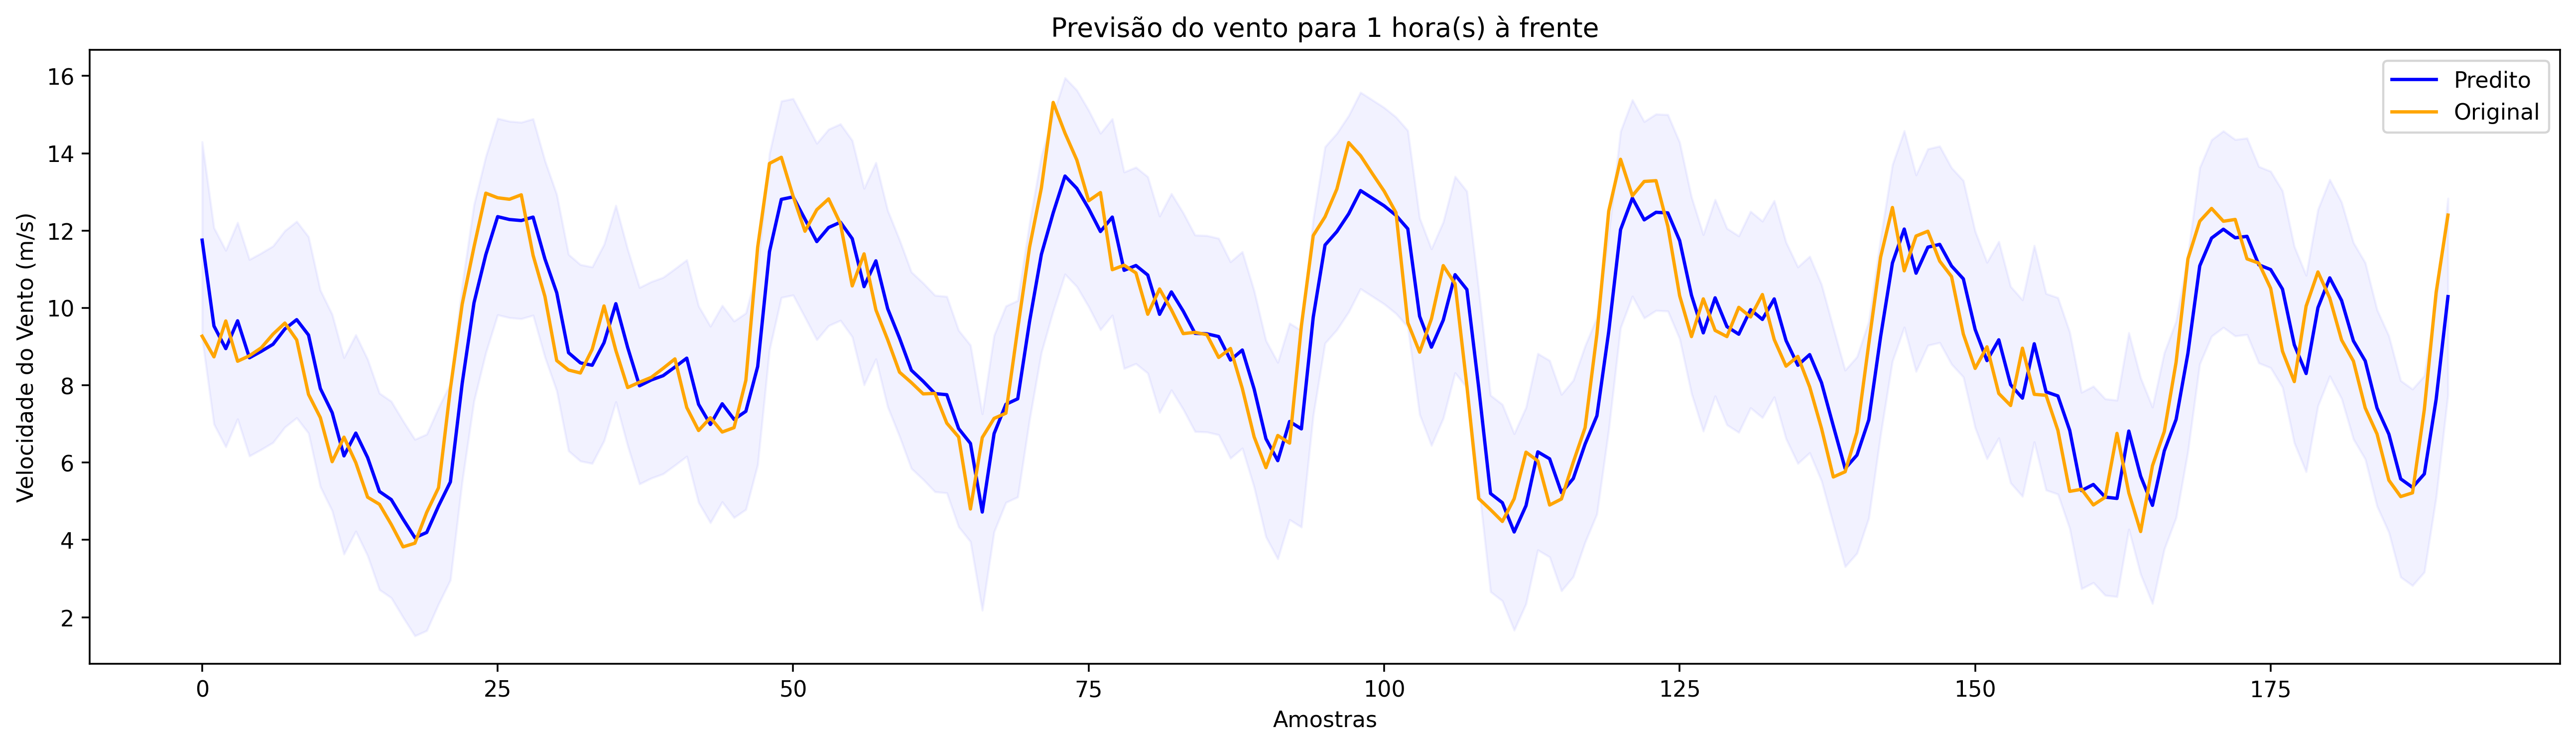

,MAE,MSE,NMSE,RMSE,NRMSE,R,R²,Fator de 2,error interval (+/-),left limit,mean,right limit
Horas à frente,,,,,,,,,,,,
1 hora,0.917849,1.326564,0.186866,1.151766,0.43228,0.901629,0.812151,1.0,2.540761,60.774974,9.048905,65.856497
Média,0.917849,1.326564,0.186866,1.151766,0.43228,0.901629,0.812151,1.0,2.540761,60.774974,9.048905,65.856497


In [39]:
erros_pd=get_plot_prediction_versus_observed(model)
erros_pd

### Função para verificar se as predições de dois modelos diferentes sobre o mesmo dataset possui diferença estatística, i.e. são equivalentes ou diferentes

In [32]:
from scipy.stats import wilcoxon
# sources: 
#   https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html
#   https://pythonfordatascienceorg.wordpress.com/wilcoxon-sign-ranked-test-python/
#   https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
# em resumo: o teste de Wilcoxon signed-rank testa a hipótese nula de que duas amostras pareadas relacionadas vêm da mesma distribuição. Ela é não paramétrica.
def verify_distribution_wilcoxtest(data1, data2, p_H0):
    stat, p = wilcoxon(data1, data2)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    if p > p_H0:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')
    return stat, p

### Verificando se há diferença estatística entre o observado e o predito

In [33]:
verify_distribution_wilcoxtest(y_test_all[:,0],predito_normal[:,0], 0.05)

Statistics=9004.000, p=0.830
Same distribution (fail to reject H0)


(9004.0, 0.8302513074896251)

### Criando novo modelo e verificando se suas predições têm ou não diferença estatística entre o modelo anterior

In [40]:
n_layers = 6
weight_shapes = {"weights_1": (n_layers,5,3)}

sampl_weights = np.random.uniform(low=0, high=np.pi, size=weight_shapes["weights_1"])
sampl_input = np.random.uniform(low=0, high=np.pi, size=(5,))
print(qml.draw(qnode, expansion_strategy="device")(sampl_input, sampl_weights))

0: ──H──RY(1.84)─╭●──Rot(2.24,2.92,0.76)──────────────────────╭●──Rot(2.72,0.68,2.19)
1: ──H──RY(2.34)─╰X─╭●────────────────────Rot(1.18,1.63,0.88)─╰X─╭●──────────────────
2: ──H──RY(1.93)─╭●─╰X────────────────────Rot(1.42,2.25,2.93)─╭●─╰X──────────────────
3: ──H──RY(1.05)─╰X─╭●────────────────────Rot(1.61,0.30,0.49)─╰X─╭●──────────────────
4: ──H──RY(0.05)────╰X────────────────────Rot(1.66,2.97,1.56)────╰X──────────────────

───────────────────────╭●──Rot(2.47,2.99,1.73)──────────────────────╭●──Rot(0.62,2.49,2.69)
───Rot(2.40,0.74,0.63)─╰X─╭●────────────────────Rot(0.77,2.52,2.75)─╰X─╭●──────────────────
───Rot(1.80,1.77,1.17)─╭●─╰X────────────────────Rot(0.28,1.38,2.93)─╭●─╰X──────────────────
───Rot(1.38,1.97,2.29)─╰X─╭●────────────────────Rot(2.40,2.69,0.12)─╰X─╭●──────────────────
───Rot(2.37,1.70,1.74)────╰X────────────────────Rot(0.06,0.82,2.76)────╰X──────────────────

───────────────────────╭●──Rot(0.20,0.90,0.68)──────────────────────╭●──Rot(1.71,2.40,1.72)
───Rot(1.22,2.83

In [41]:
q_layer2 = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model2 = tf.keras.models.Sequential([q_layer2,Activation, output_layer])
model2.compile(opt, loss="mse")
model2.build(input_shape)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (5, 5)                    90        
                                                                 
 activation (Activation)     (5, 5)                    0         
                                                                 
 dense (Dense)               (5, 1)                    6         
                                                                 
Total params: 96
Trainable params: 96
Non-trainable params: 0
_________________________________________________________________


In [42]:
history_model2 = model2.fit(X_train, y_train, epochs=50, batch_size=1, callbacks=[re], verbose=1, validation_data=(X_val, y_val))

Epoch 1/50
437/437 [==============================] - 448s 1s/step - loss: 0.0424 - val_loss: 0.0326 - lr: 1.0000e-05
Epoch 2/50
437/437 [==============================] - 452s 1s/step - loss: 0.0422 - val_loss: 0.0326 - lr: 1.0000e-05
Epoch 3/50
437/437 [==============================] - 473s 1s/step - loss: 0.0421 - val_loss: 0.0327 - lr: 1.0000e-05
Epoch 4/50
437/437 [==============================] - 490s 1s/step - loss: 0.0419 - val_loss: 0.0328 - lr: 1.0000e-05
Epoch 5/50
437/437 [==============================] - 475s 1s/step - loss: 0.0418 - val_loss: 0.0328 - lr: 1.0000e-05
Epoch 6/50
437/437 [==============================] - 454s 1s/step - loss: 0.0417 - val_loss: 0.0328 - lr: 1.0000e-05
Epoch 7/50
437/437 [==============================] - 456s 1s/step - loss: 0.0416 - val_loss: 0.0328 - lr: 1.0000e-05
Epoch 8/50
437/437 [==============================] - 461s 1s/step - loss: 0.0415 - val_loss: 0.0329 - lr: 1.0000e-05
Epoch 9/50
437/437 [==============================] - 45

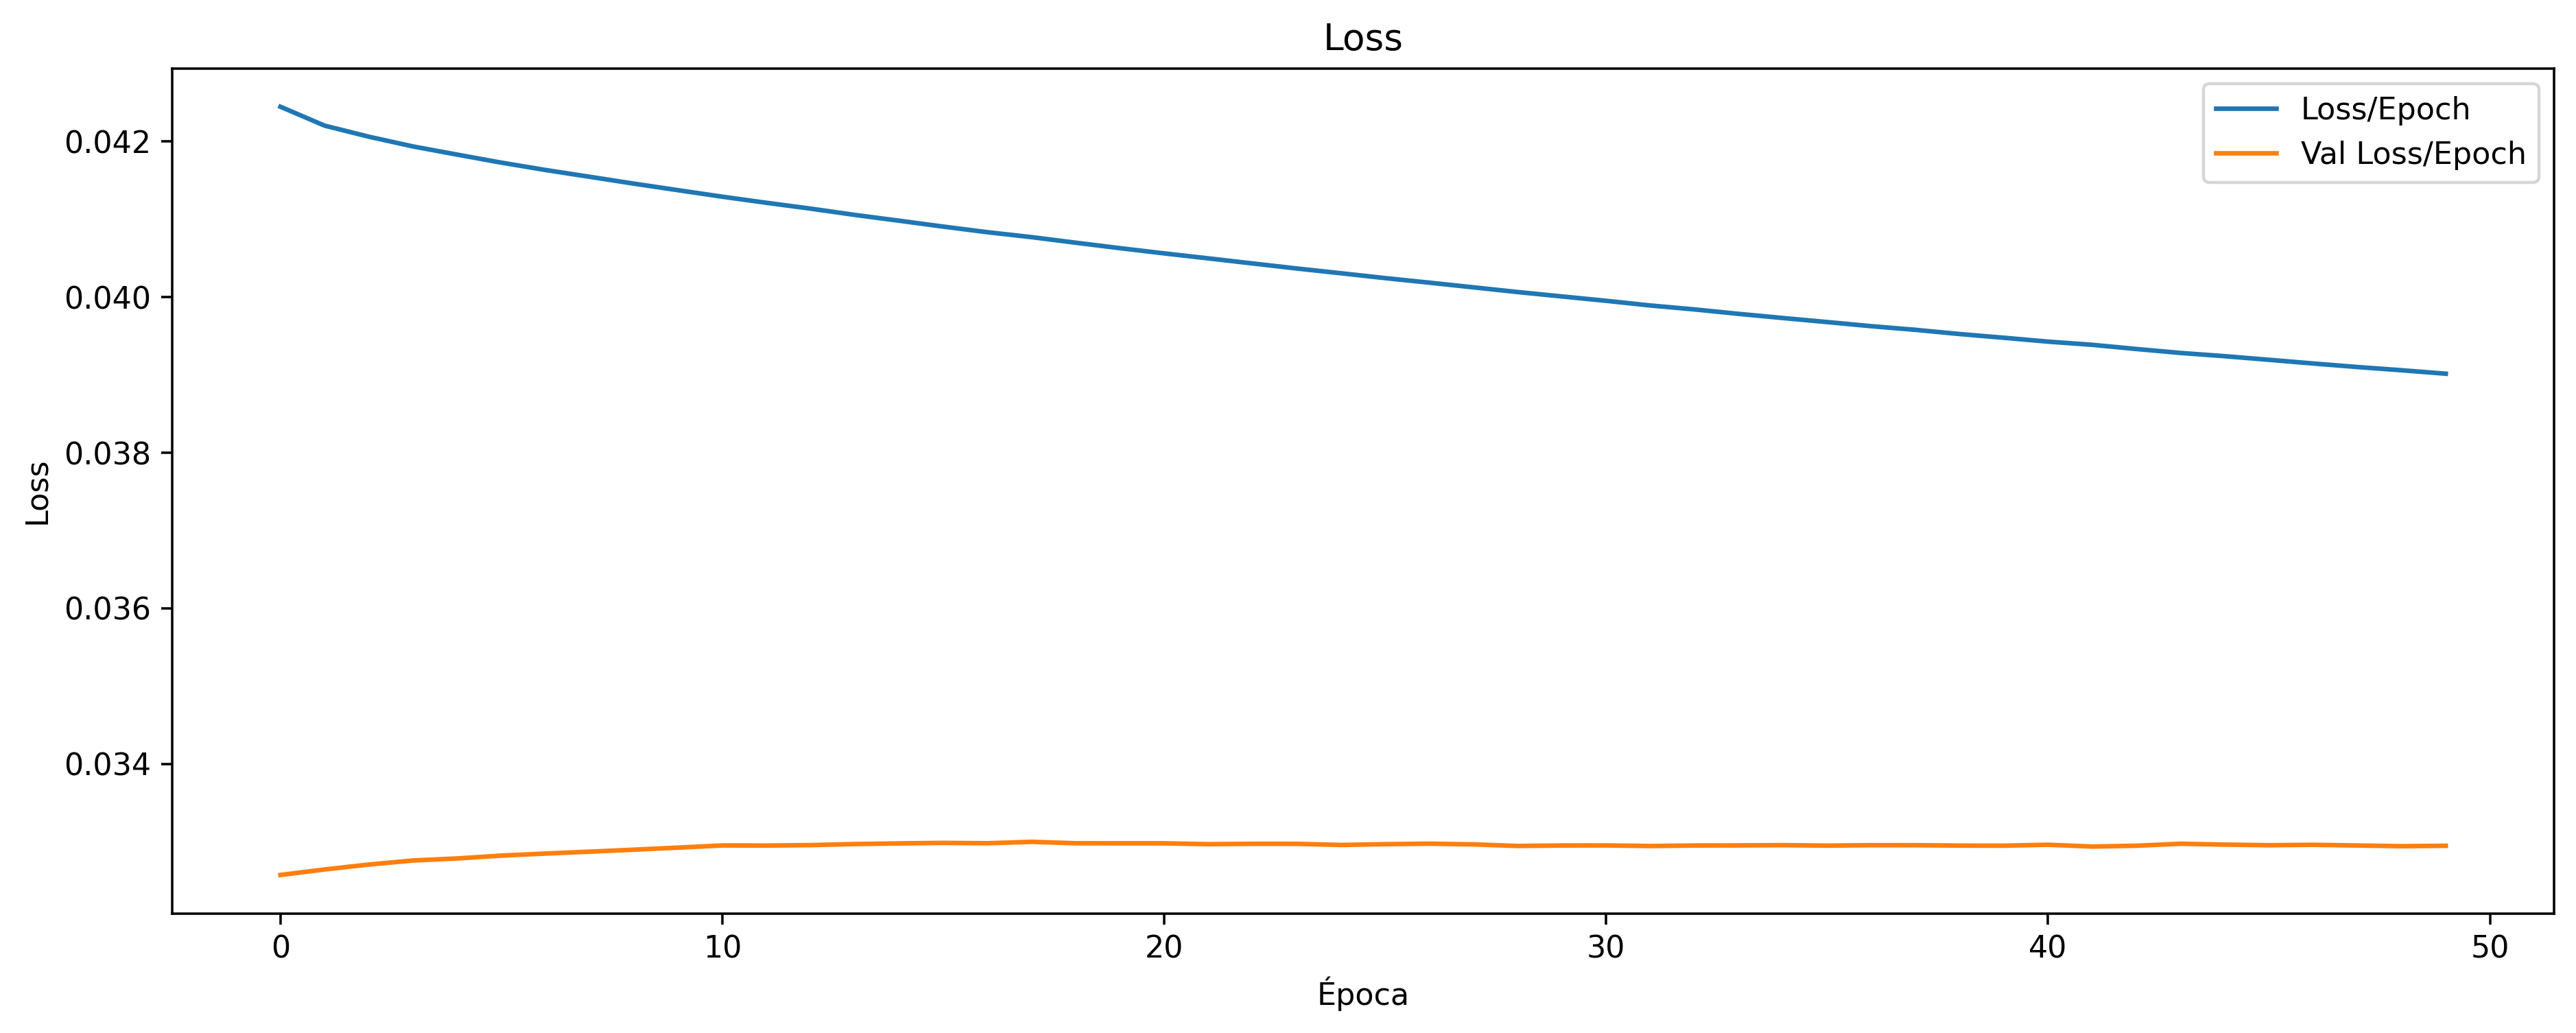

In [43]:
predito2 = model2.predict(X_test_scaled)
predito2_normal = scaler_y.inverse_transform(predito2)
plot_history(history_model2)

In [44]:
verify_distribution_wilcoxtest(predito_normal[:,0],predito2_normal[:,0], 0.05)

Statistics=1670.000, p=0.000
Different distribution (reject H0)


(1670.0, 1.1112873137989442e-22)

MAE: 0.9178488955821741
MSE: 1.3265640762581299
NMSE: 0.1868659538911826
RMSE: 1.1517656342581724
NRMSE: 0.43227994851852963
R: 0.9016293490736955
R²: 0.8121505410883375
Fator de 2: 1.0


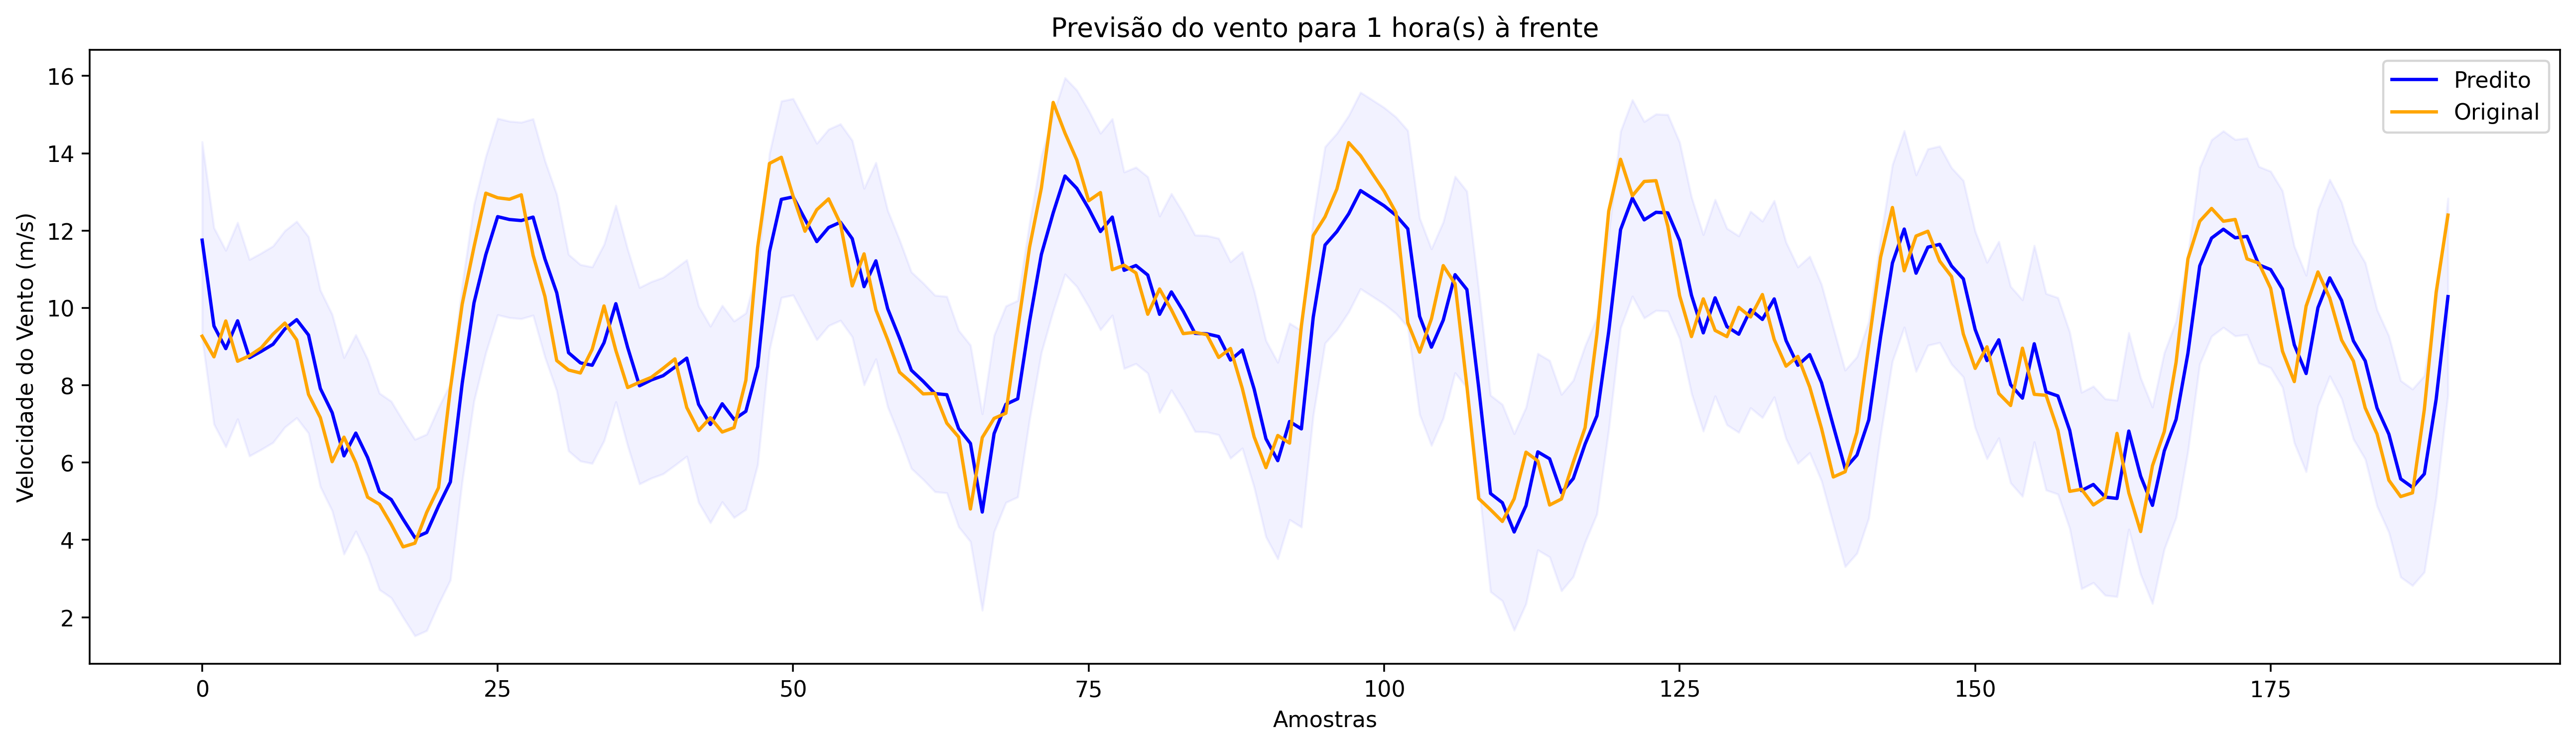

,MAE,MSE,NMSE,RMSE,NRMSE,R,R²,Fator de 2,error interval (+/-),left limit,mean,right limit
Horas à frente,,,,,,,,,,,,
1 hora,0.917849,1.326564,0.186866,1.151766,0.43228,0.901629,0.812151,1.0,2.540761,60.774974,9.048905,65.856497
Média,0.917849,1.326564,0.186866,1.151766,0.43228,0.901629,0.812151,1.0,2.540761,60.774974,9.048905,65.856497


In [46]:
erros2_pd=get_plot_prediction_versus_observed(model2)
erros2_pd